In [42]:
import numpy as np
import matplotlib.pyplot as plt
import mrcfile
import os
import logging
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
from aspire.utils.filters import RadialCTFFilter
from aspire.source.simulation import Simulation
from aspire.utils.coor_trans import uniform_random_angles
from aspire.utils.matlab_compat import Random
from aspire.image import Image
from aspire.utils.matrix import anorm
from aspire.utils.matlab_compat import randn
from aspire.io.starfile import save_star

In [3]:
from utils_ascep import visualise_images, matlab2py

Two conformations
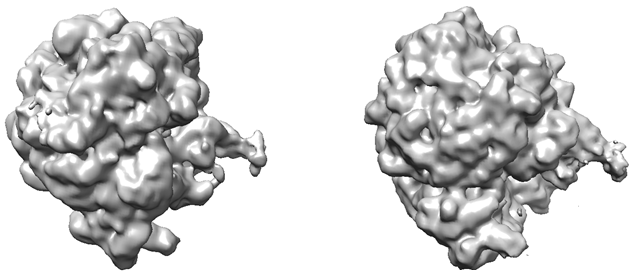

In [4]:
logger = logging.getLogger('aspire')
DATA_DIR = '../data/'

In [5]:
logger.info('This script illustrates 2D covariance Wiener filtering functionality in ASPIRE package.')

2020/04/10 16:49:13 This script illustrates 2D covariance Wiener filtering functionality in ASPIRE package.


In [6]:
# Set the sizes of images
img_size = 130
# Set the total number of images generated from the 3D map
num_imgs = 5000
duplicate = 100

# Set the number of 3D maps
num_maps = 1

# Set the signal-noise ratio
sn_ratio = 0.1

# Specify the CTF parameters
pixel_size = 2.82                # Pixel size of the images (in angstroms).
voltage = 200                    # Voltage (in KV)
defocus_min = 1.5e4              # Minimum defocus value (in angstroms).
defocus_max = 2.0e4              # Maximum defocus value (in angstroms).
defocus_ct = 50                 # Number of defocus groups.
Cs = 2.0                         # Spherical aberration
alpha = 0.1                      # Amplitude contrast

In [7]:
# Create filters
filters = [RadialCTFFilter(pixel_size, voltage, defocus=d, Cs=2.0, alpha=0.1)
           for d in np.linspace(defocus_min, defocus_max, defocus_ct)]

In [37]:
infile = mrcfile.open(os.path.join(DATA_DIR, '70S_Conform1.mrc'))
vols = infile.data
vols = vols[..., np.newaxis]

In [12]:
# a total of 50 distinct 2D imageswere generated by projecting the 3D structure of 70S ribosome in equally spaced (angle-wise) 
# orientations. 5,000 images were generated from these 50 projections by making 100 copies for each projection. 
# For each projection, the 100 copies from i = 1 to i = 100 are uniformly rotated with 3:6i degree.

# https://en.wikipedia.org/wiki/Euler_angles#Definition_by_intrinsic_rotations   zyz convention
with Random(seed=0):
    rot = np.repeat(np.random.random(int(num_imgs/duplicate)) * 2 * np.pi, duplicate)          #alpha
    tilt = np.repeat(np.arccos(2 * np.random.random(int(num_imgs/duplicate)) - 1), duplicate)  #beta
    psi = np.tile(np.linspace(0, 2*np.pi, duplicate, endpoint=False), int(num_imgs/duplicate)) #gamma (in-plane rotation)
my_angles = np.column_stack((rot, tilt, psi))

In [13]:
sim = Simulation(
    n=num_imgs,
    vols=vols,
    C=num_maps,
    filters=filters,
    L = img_size,
    angles = my_angles, 
    offsets = np.zeros([num_imgs,2]),
    amplitudes = np.ones(num_imgs)
)

In [14]:
sim._metadata

_rlnClassNumber                                           __filter  \
0                   1  <aspire.utils.filters.RadialCTFFilter object a...   
1                   1  <aspire.utils.filters.RadialCTFFilter object a...   
2                   1  <aspire.utils.filters.RadialCTFFilter object a...   
3                   1  <aspire.utils.filters.RadialCTFFilter object a...   
4                   1  <aspire.utils.filters.RadialCTFFilter object a...   
...               ...                                                ...   
4995                1  <aspire.utils.filters.RadialCTFFilter object a...   
4996                1  <aspire.utils.filters.RadialCTFFilter object a...   
4997                1  <aspire.utils.filters.RadialCTFFilter object a...   
4998                1  <aspire.utils.filters.RadialCTFFilter object a...   
4999                1  <aspire.utils.filters.RadialCTFFilter object a...   

      _rlnVoltage  _rlnDefocusU  _rlnDefocusV  _rlnDefocusAngle  \
0           200.0  19081.632653  19081.632653               0.0   
1           200.0  19591.836735  19591.836735               0.0   
2           200.0  15612.244898  15612.244898               0.0   
3           200.0  19591.836735  19591.836735               0.0   
4           200.0  18163.265306  18163.265306               0.0   
...           ...           ...           ...               ...   
4995        200.0  16632.653061  16632.653061               0.0   
4996        200.0  18367.346939  18367.346939               0.0   
4997        200.0  16428.571429  16428.571429               0.0   
4998        200.0  19693.877551  19693.877551               0.0   
4999        200.0  16428.571429  16428.571429               0.0   

      _rlnSphericalAberration  _rlnAmplitudeContrast  _rlnOriginX  \
0                         2.0                    0.1          0.0   
1                         2.0                    0.1          0.0   
2                         2.0                    0.1          0.0   
3                         2.0                    0.1          0.0   
4                         2.0                    0.1          0.0   
...                       ...                    ...          ...   
4995                      2.0                    0.1          0.0   
4996                      2.0                    0.1          0.0   
4997                      2.0                    0.1          0.0   
4998                      2.0                    0.1          0.0   
4999                      2.0                    0.1          0.0   

      _rlnOriginY  _rlnAmplitude  _rlnAngleRot  _rlnAngleTilt  _rlnAnglePsi  
0             0.0            1.0    293.300527     116.612224           0.0  
1             0.0            1.0    293.300527     116.612224           3.6  
2             0.0            1.0    293.300527     116.612224           7.2  
3             0.0            1.0    293.300527     116.612224          10.8  
4             0.0            1.0    293.300527     116.612224          14.4  
...           ...            ...           ...            ...           ...  
4995          0.0            1.0    271.687206     109.011305         342.0  
4996          0.0            1.0    271.687206     109.011305         345.6  
4997          0.0            1.0    271.687206     109.011305         349.2  
4998          0.0            1.0    271.687206     109.011305         352.8  
4999          0.0            1.0    271.687206     109.011305         356.4  

[5000 rows x 14 columns]

In [15]:
# Generate 2D clean images from input 3D map. The following statement can be used from the sim object:
imgs_clean = sim.projections(start=0, num=num_imgs)

2020/04/10 16:50:47 Trying NFFT backend finufft
2020/04/10 16:50:47 NFFT backend finufft usable
2020/04/10 16:50:47 Trying NFFT backend pynfft
2020/04/10 16:50:47 NFFT backend pynfft not usable
2020/04/10 16:50:47 Selected NFFT backend = finufft


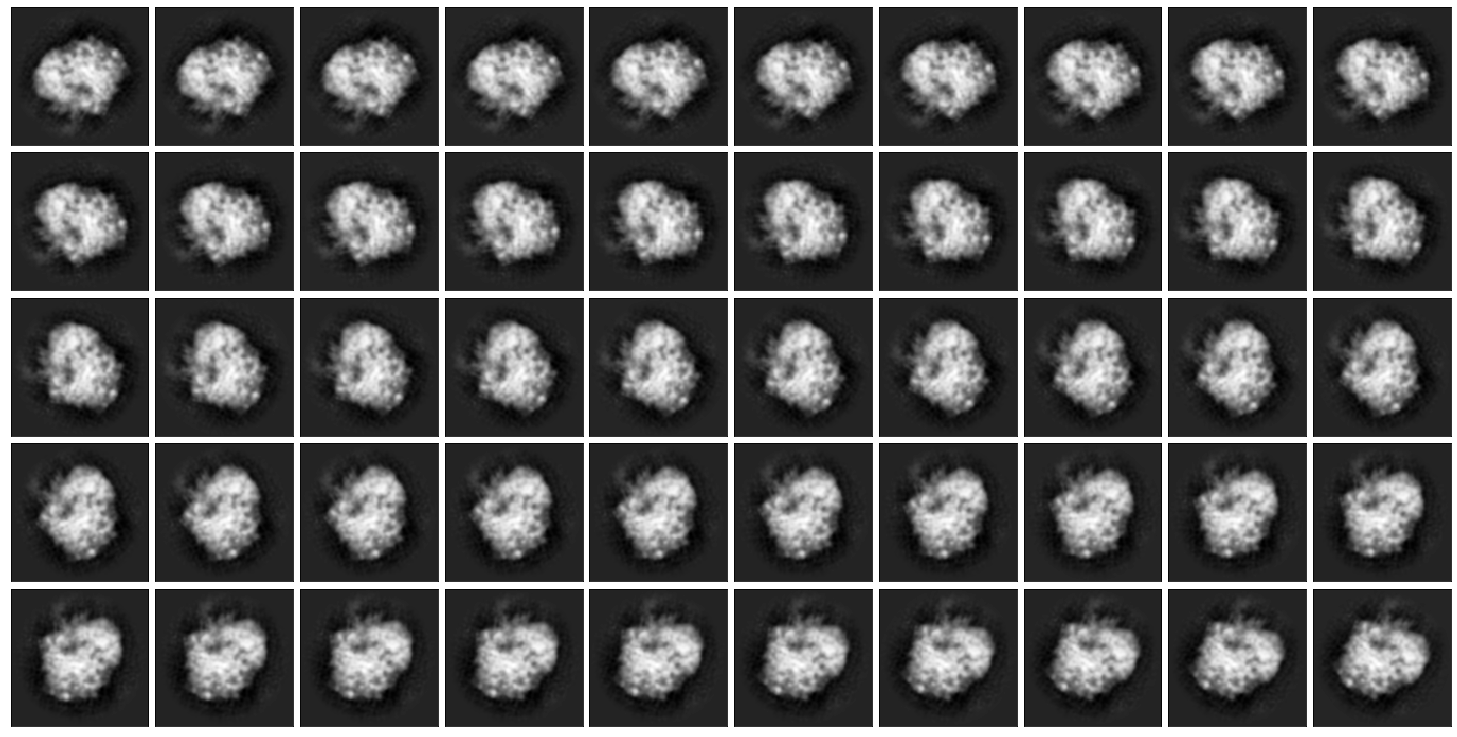

In [16]:
visualise_images(matlab2py(imgs_clean.asnumpy()), 50 , 10, False)

In [17]:
# Apply the CTF to the clean images.
imgs_ctf_clean = sim.eval_filters(imgs_clean)

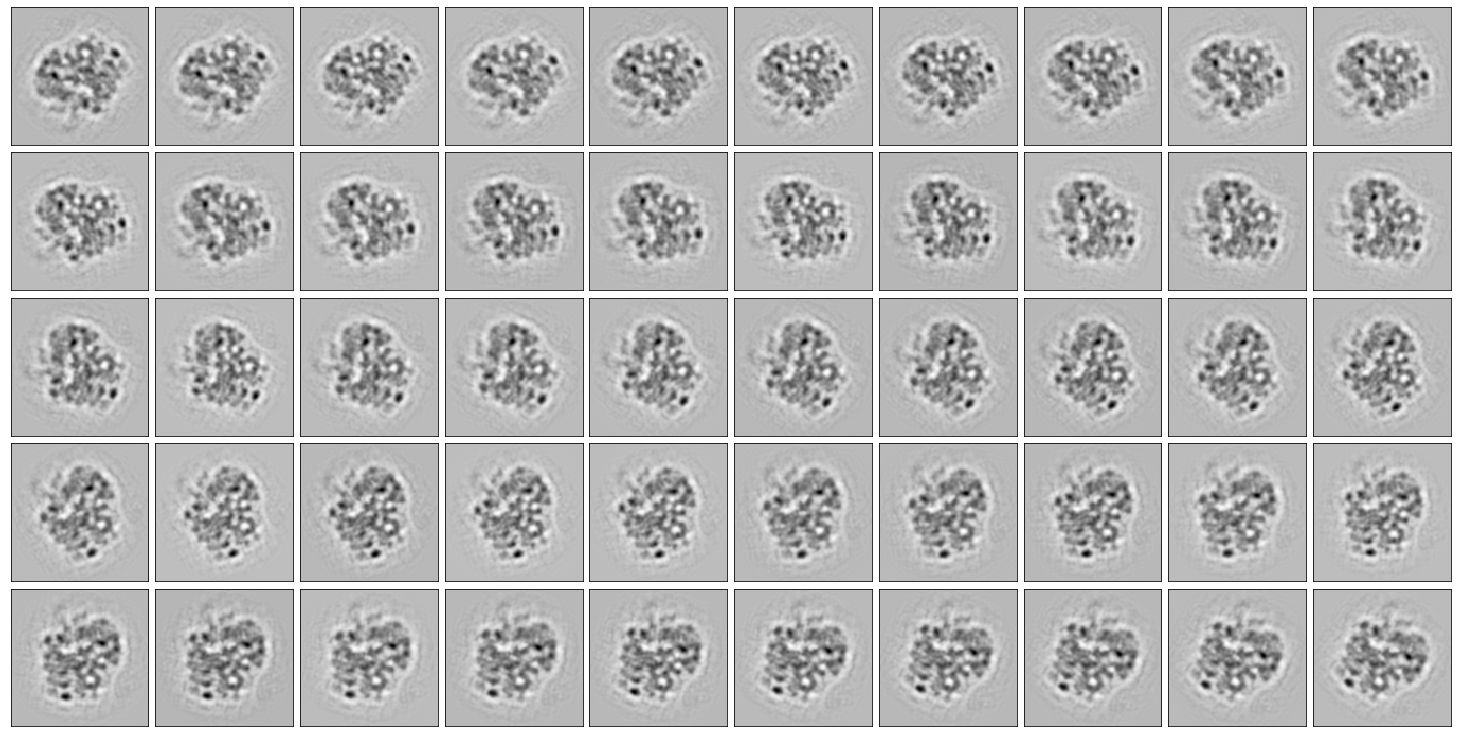

In [18]:
visualise_images(matlab2py(imgs_ctf_clean.asnumpy()), 50 , 10, False)

In [21]:
# imgs_ctf_clean is an Image object. Convert to numpy array for subsequent statements
imgs_ctf_clean = imgs_ctf_clean.asnumpy()

# Apply the noise at the desired singal-noise ratio to the filtered clean images
power_clean = anorm(imgs_ctf_clean)**2/np.size(imgs_ctf_clean) # first definition in wiki
power_clean, imgs_ctf_clean.var() # subtract mean, definition in ESL (https://stats.stackexchange.com/questions/31158/how-to-simulate-signal-noise-ratio)

(0.0005057052652007685, 0.0004824557713924697)

In [22]:
noise_var = imgs_ctf_clean.var()/sn_ratio
imgs_noise = imgs_ctf_clean + np.sqrt(noise_var)*randn(img_size, img_size, num_imgs, seed=0)

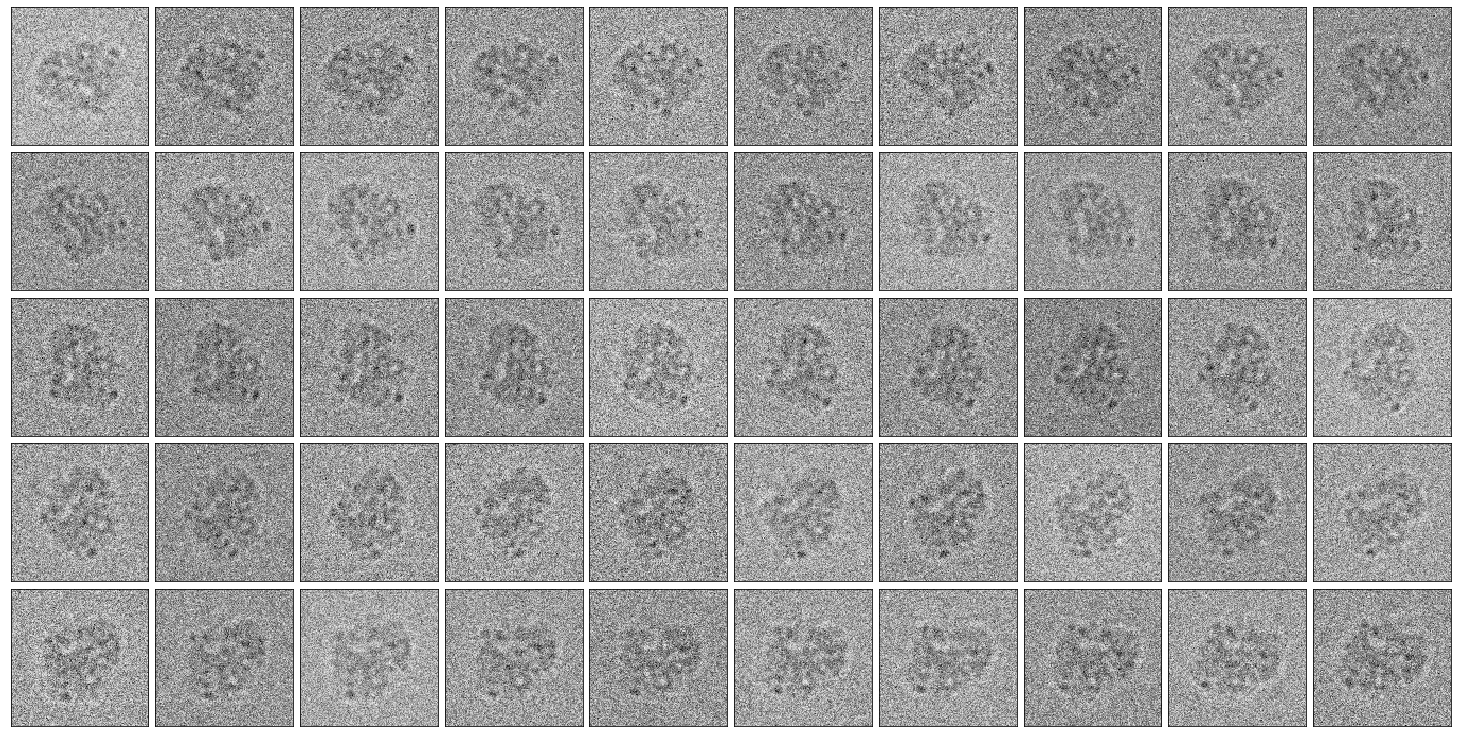

In [23]:
visualise_images(matlab2py(imgs_noise), 50 , 10, False)

In [32]:
imgs_noise.shape

(130, 130, 5000)

In [33]:
sim._im = np.swapaxes(imgs_noise, 0,1)

In [34]:
save_star(sim, "simulate.star", batch_size=num_imgs, overwrite=True)

2020/04/10 17:40:17 Saving ImageSource[0-5000] to simulate_0_5000.mrcs
2020/04/10 17:40:17 Loading images from cache
2020/04/10 17:40:18 Loaded 5000 images


C:\Users\phonchi\Anaconda3\lib\site-packages\aspire-0.5.28-py3.7.egg\aspire\io\starfile.py:201: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_rlnImageName'][i_start: i_end] = pd.Series(['{0:06}@{1}'.format(j + 1, mrcs_filepath) for j in range(num)])


In [35]:
# Read Back the image
infile = mrcfile.open('simulate_0_5000.mrcs')
imgs = infile.data

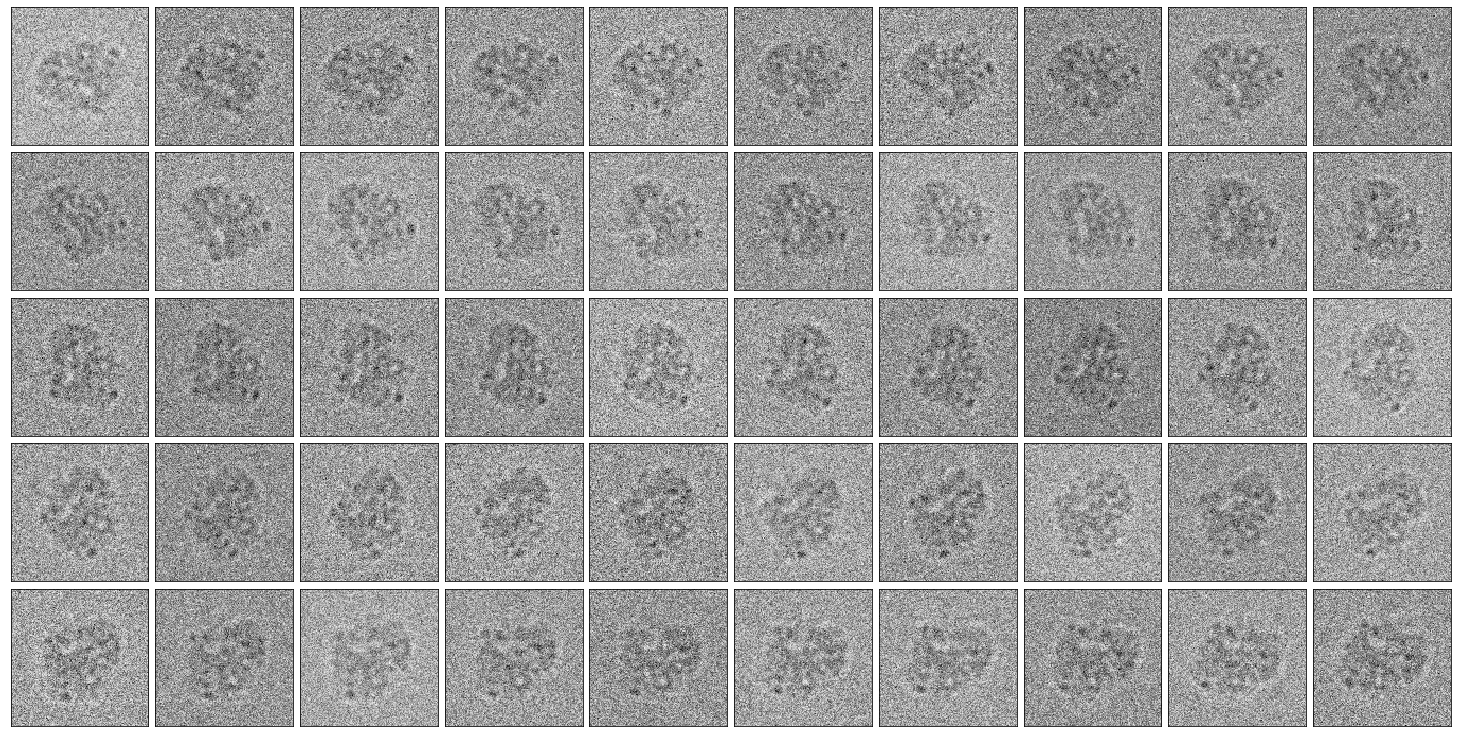

In [36]:
visualise_images(imgs, 50 , 10, False)

In [ ]:
def matlab2py(i_matrix):
    tmp = np.swapaxes(i_matrix,0,2)
    return np.swapaxes(tmp,1,2).copy()